# Lectura y Análisis

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [153]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [154]:
# Read the CSV files
directory = "data/"
cristianos_openmetoe_arpege = "openmeteo_cristianos_arpege.csv"
cristianos_openmetoe_icon = "openmeteo_cristianos_icon.csv"
cuesta_openmetoe_arpege = "openmeteo_cuesta_arpege.csv"
cuesta_openmetoe_icon = "openmeteo_cuesta_icon.csv"
orotava_openmetoe_arpege = "openmeteo_orotava_arpege.csv"
orotava_openmetoe_icon = "openmeteo_orotava_icon.csv"

cristianos_grafcan = "grafcan_cristianos.csv"
cuesta_grafcan = "grafcan_cuesta.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [cristianos_openmetoe_arpege,
              cristianos_openmetoe_icon,
              cuesta_openmetoe_arpege,
              cuesta_openmetoe_icon,
              orotava_openmetoe_arpege,
              orotava_openmetoe_icon,
              cuesta_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_cristianos_arpege.csv...
Processing openmeteo_cristianos_icon.csv...
Processing openmeteo_cuesta_arpege.csv...
Processing openmeteo_cuesta_icon.csv...
Processing openmeteo_orotava_arpege.csv...
Processing openmeteo_orotava_icon.csv...
Processing grafcan_cuesta.csv...


## Visualización

In [155]:
def plot_datasets(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    # Find common years between both datasets
    common_years = set(df1.index.year.unique()) & set(df2.index.year.unique())
    
    for year in common_years:
        df1_year = df1[df1.index.year == year]
        df2_year = df2[df2.index.year == year]
        
        plt.figure(figsize=(10, 6))
        for column in df1_year.columns:
            if column in df2_year.columns:  # Plot only common columns
                plt.plot(df1_year.index, df1_year[column], 
                         label=f"{file1} - {column}", linestyle='-', alpha=0.7)
                plt.plot(df2_year.index, df2_year[column], 
                         label=f"{file2} - {column}", linestyle='--', alpha=0.7)
        
        plt.title(f'Comparison Plot - {file1} vs {file2} - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

In [156]:
def load_vanilla(file, directory):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        
        # Display the first few rows to confirm the data was loaded correctly
        print(df.head())
        
        # Sort by date
        df = df.sort_index()

        # Resample data by hour and calculate the mean
        df_hourly = df.resample('h').mean()  # 'h' for hourly resampling

        # Store the dataframe for further processing with modified index
        dataframes[file_key] = df_hourly
        
        # Extract the unique years in the dataset
        unique_years = df_hourly.index.year.unique()
        
        # Plot a separate chart for each year
        for year in unique_years:
            df_year = df_hourly[df_hourly.index.year == year]
            
            plt.figure(figsize=(10, 6))
            df_year.plot()
            plt.title(f'Time Series Plot - {file} - Year {year}')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.grid(True)
            plt.show()
        
    except Exception as e:
        print(f"Error processing {file}: {e}")

### OpenMeteo

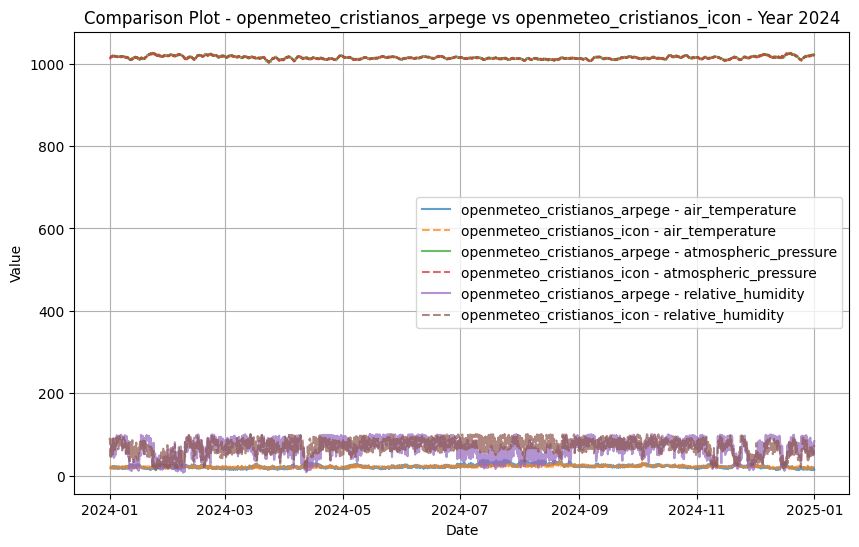

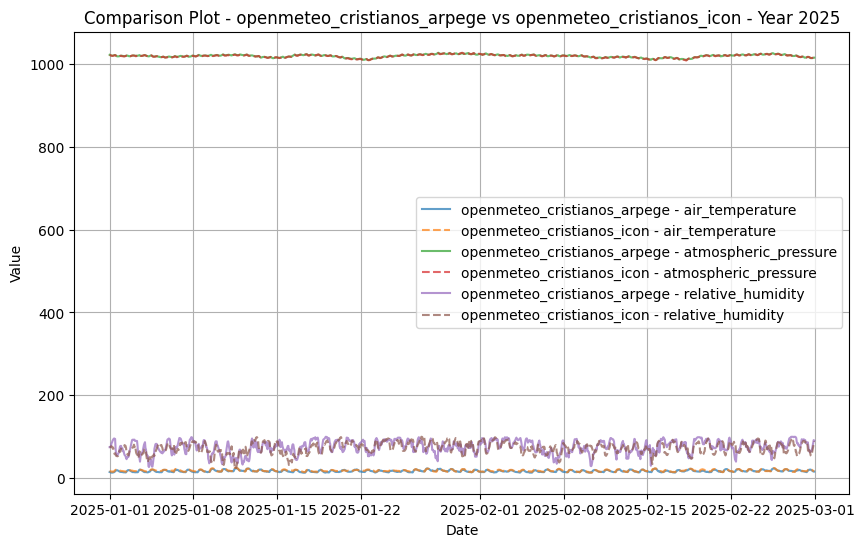

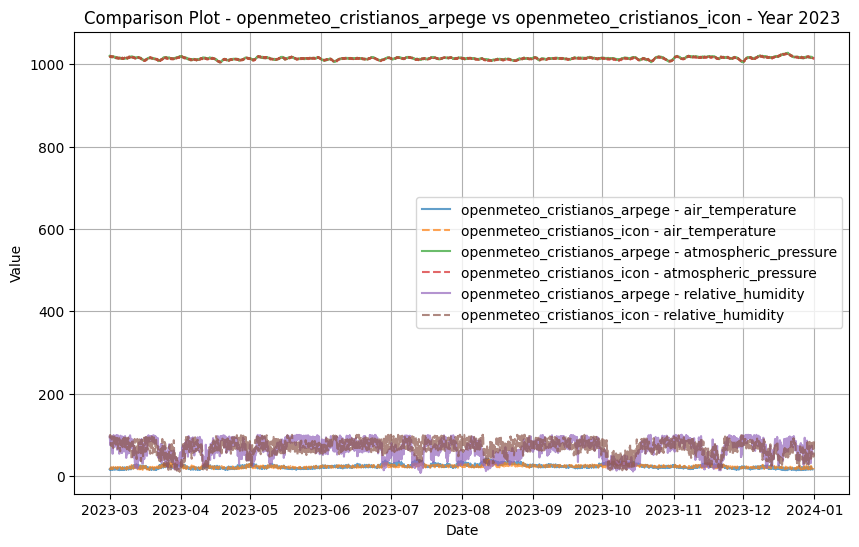

In [157]:
plot_datasets(cristianos_openmetoe_arpege, cristianos_openmetoe_icon)

## Horas faltantes

In [158]:
    
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours)
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_cristianos_arpege after resampling:
DatetimeIndex(['2023-12-31 07:00:00+00:00', '2023-12-31 08:00:00+00:00',
               '2023-12-31 09:00:00+00:00', '2023-12-31 10:00:00+00:00',
               '2023-12-31 11:00:00+00:00', '2023-12-31 12:00:00+00:00',
               '2023-12-31 13:00:00+00:00', '2023-12-31 14:00:00+00:00',
               '2023-12-31 15:00:00+00:00', '2023-12-31 16:00:00+00:00',
               '2023-12-31 17:00:00+00:00', '2023-12-31 18:00:00+00:00',
               '2023-12-31 19:00:00+00:00', '2023-12-31 20:00:00+00:00',
               '2023-12-31 21:00:00+00:00', '2023-12-31 22:00:00+00:00',
               '2023-12-31 23:00:00+00:00', '2024-01-01 00:00:00+00:00',
               '2024-01-01 01:00:00+00:00', '2024-01-01 02:00:00+00:00',
               '2024-01-01 03:00:00+00:00', '2024-01-01 04:00:00+00:00',
               '2024-01-01 05:00:00+00:00', '2024-01-01 06:00:00+00:00',
               '2024-01-01 07:00:00+00:00', '2024-01-01 08:00

### Manejo Horas faltantes

In [159]:
# Cubic Spline Interpolation Algorithm

def cubic_spline_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [160]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    cubic_spline_interpolation(df_hourly)

## Comparativa datasets predicciones

In [161]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    # Find common years between both datasets
    common_years = set(df1.index.year.unique()) & set(df2.index.year.unique())
    
    for year in common_years:
        df1_year = df1[df1.index.year == year]
        df2_year = df2[df2.index.year == year]
        
        similarity_results = {}
        for column in df1_year.columns:
            if column in df2_year.columns:
                try:
                    pearson_corr, _ = pearsonr(df1_year[column], df2_year[column])
                    spearman_corr, _ = spearmanr(df1_year[column], df2_year[column])
                    kendall_corr, _ = kendalltau(df1_year[column], df2_year[column])
                    mse = mean_squared_error(df1_year[column], df2_year[column])
                    euclid_dist = euclidean(df1_year[column], df2_year[column])
                    
                    similarity_results[column] = {
                        "Pearson": pearson_corr,
                        "Spearman": spearman_corr,
                        "Kendall": kendall_corr,
                        "MSE": mse,
                        "Euclidean Distance": euclid_dist
                    }
                except Exception as e:
                    print(f"Error calculating similarity for {column} in year {year}: {e}")
        
        print(f"Similarity Metrics for {file1} vs {file2} - Year {year}")
        for col, metrics in similarity_results.items():
            print(f"  {col}:")
            for metric, value in metrics.items():
                print(f"    {metric}: {value:.4f}")


In [162]:
datasets_similarity(cuesta_openmetoe_icon, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_icon vs grafcan_cuesta - Year 2024
  air_temperature:
    Pearson: 0.8672
    Spearman: 0.8892
    Kendall: 0.7313
    MSE: 2.5392
    Euclidean Distance: 149.3473
  atmospheric_pressure:
    Pearson: 0.9880
    Spearman: 0.9837
    Kendall: 0.8991
    MSE: 0.4871
    Euclidean Distance: 65.4138
  relative_humidity:
    Pearson: 0.5194
    Spearman: 0.5580
    Kendall: 0.4200
    MSE: 188.0189
    Euclidean Distance: 1285.1294
Similarity Metrics for openmeteo_cuesta_icon vs grafcan_cuesta - Year 2025
  air_temperature:
    Pearson: 0.8354
    Spearman: 0.8614
    Kendall: 0.6761
    MSE: 1.6728
    Euclidean Distance: 48.6688
  atmospheric_pressure:
    Pearson: 0.9942
    Spearman: 0.9927
    Kendall: 0.9325
    MSE: 0.1790
    Euclidean Distance: 15.9190
  relative_humidity:
    Pearson: 0.6363
    Spearman: 0.6580
    Kendall: 0.4894
    MSE: 73.1708
    Euclidean Distance: 321.8848
Similarity Metrics for openmeteo_cuesta_icon vs grafcan_cuest

In [163]:
datasets_similarity(cuesta_openmetoe_arpege, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_arpege vs grafcan_cuesta - Year 2024
  air_temperature:
    Pearson: 0.8086
    Spearman: 0.8441
    Kendall: 0.6802
    MSE: 3.6616
    Euclidean Distance: 179.3412
  atmospheric_pressure:
    Pearson: 0.9884
    Spearman: 0.9854
    Kendall: 0.9037
    MSE: 0.2987
    Euclidean Distance: 51.2226
  relative_humidity:
    Pearson: 0.3817
    Spearman: 0.4874
    Kendall: 0.3724
    MSE: 266.8502
    Euclidean Distance: 1531.0168
Similarity Metrics for openmeteo_cuesta_arpege vs grafcan_cuesta - Year 2025
  air_temperature:
    Pearson: 0.8543
    Spearman: 0.8659
    Kendall: 0.6847
    MSE: 1.2297
    Euclidean Distance: 41.7284
  atmospheric_pressure:
    Pearson: 0.9940
    Spearman: 0.9917
    Kendall: 0.9288
    MSE: 0.1995
    Euclidean Distance: 16.8068
  relative_humidity:
    Pearson: 0.5891
    Spearman: 0.6315
    Kendall: 0.4630
    MSE: 132.7816
    Euclidean Distance: 433.6113
Similarity Metrics for openmeteo_cuesta_arpege vs grafca

## Detección de outliers



In [164]:
def detect_outliers_iqr(df, threshold=1.5):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
    """
    outliers_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        
        # Plot
        plt.figure(figsize=(6, 4))
        plt.boxplot(df[column], vert=False)
        plt.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        plt.title(f'Boxplot of {column}')
        plt.legend()
        plt.xlabel(column)
        plt.show()
    
    return outliers_dict

Outliers detected in openmeteo_cristianos_arpege:


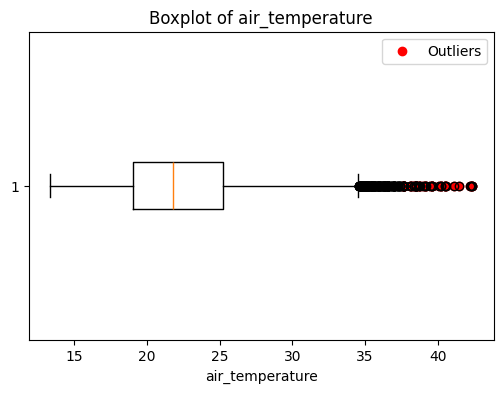

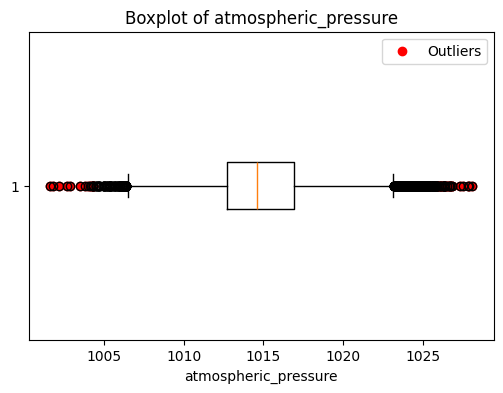

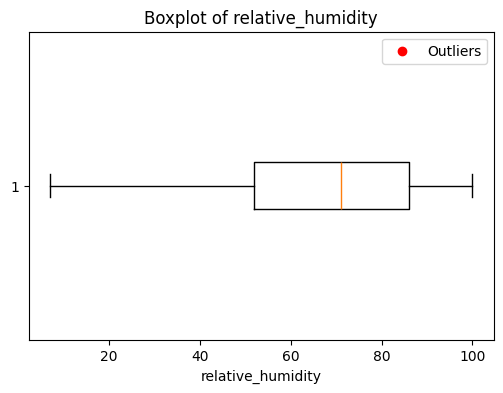

  air_temperature: [37.7, 37.7, 38.5, 37.6, 38.7, 39.1, 38.7, 37.7, 39.5, 38.2, 41.5, 42.3, 42.2, 42.4, 42.4, 41.1, 40.2, 40.5, 40.5, 39.6, 38.5, 38.5, 40.1, 40.2, 39.6, 39.1, 38.8, 38.5, 39.2, 40.6, 37.7, 37.6, 38.4, 39.6, 38.5, 38.1, 39.0, 38.5, 38.2, 37.6, 38.4]
  atmospheric_pressure: [1004.3, 1025.4, 1025.6, 1025.4, 1025.5, 1025.9, 1026.3, 1026.7, 1026.7, 1026.1, 1025.3, 1025.3, 1025.7, 1026.1, 1026.5, 1026.7, 1026.3, 1026.3, 1026.4, 1026.3, 1026.0, 1025.9, 1026.3, 1026.6, 1026.8, 1027.5, 1027.8, 1027.9, 1028.1, 1027.3, 1026.3, 1025.7, 1025.6, 1025.8, 1025.3, 1025.6, 1026.0, 1025.7, 1025.7, 1025.5, 1025.9, 1025.4, 1025.3, 1025.5, 1025.7, 1025.3, 1004.3, 1004.1, 1003.8, 1002.7, 1001.8, 1001.6, 1002.2, 1002.9, 1003.5, 1004.3, 1004.2, 1004.0, 1004.3, 1004.3, 1025.6, 1025.4, 1025.6, 1025.7, 1025.7, 1025.7, 1025.3, 1025.3, 1025.9, 1026.3, 1026.4, 1025.5, 1025.5, 1025.5, 1025.8, 1026.8, 1026.1, 1025.4, 1025.8, 1026.5, 1025.8, 1025.4, 1025.3, 1025.3, 1026.2, 1025.8, 1025.3, 1025.3, 1025.

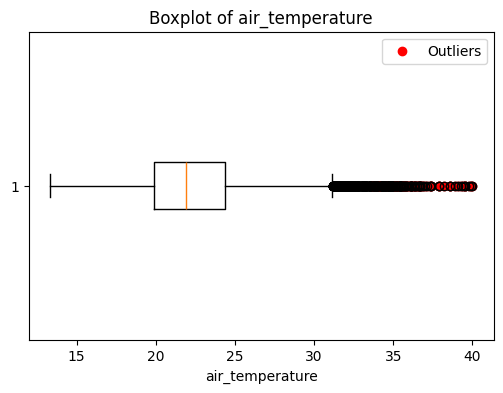

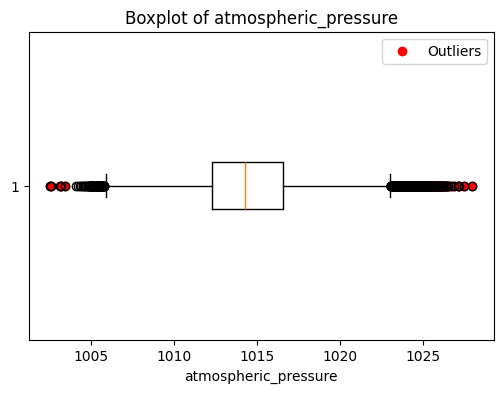

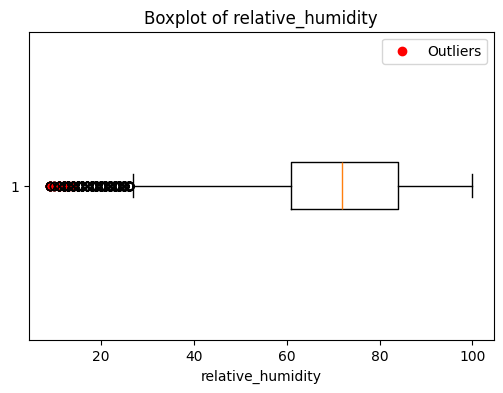

  air_temperature: [33.5, 33.5, 34.4, 35.4, 36.1, 36.4, 36.1, 35.5, 34.5, 34.8, 34.3, 35.0, 35.7, 35.9, 35.4, 34.6, 34.0, 33.5, 34.5, 35.3, 35.5, 35.7, 34.6, 34.0, 33.7, 34.7, 35.2, 35.3, 36.7, 35.2, 36.8, 38.6, 38.6, 39.4, 39.5, 39.3, 36.5, 33.9, 35.8, 37.4, 40.0, 39.9, 39.8, 39.5, 39.1, 38.9, 35.4, 34.1, 34.8, 36.4, 36.3, 34.3, 33.9, 33.6, 34.8, 34.7, 34.6, 34.7, 34.3, 33.8, 36.0, 37.0, 37.4, 37.3, 36.9, 35.6, 34.3, 33.9, 34.1, 33.6, 34.1, 34.3, 34.3, 35.4, 36.3, 36.7, 37.9, 37.9, 38.2, 37.1, 36.6, 35.5, 34.0, 35.0, 35.4, 34.9, 34.5, 33.6, 34.5, 35.3, 35.8, 36.1, 36.1, 35.8, 35.3, 34.6, 35.1, 34.7, 34.9, 35.1, 35.0, 34.6, 34.2, 33.8, 34.4, 34.9, 34.9, 34.9, 34.7, 35.0, 34.7, 34.1, 34.3, 34.2, 34.8, 35.2, 35.5, 35.2, 34.7, 33.7, 34.8, 34.4, 34.4, 34.4, 34.3, 33.8, 33.5, 34.0, 33.5, 33.5, 33.8, 33.7, 33.9, 34.3, 34.6, 34.9, 34.9, 34.5, 33.6, 35.0, 36.1, 36.6, 36.7, 36.5, 36.2, 35.8, 34.8, 34.2, 33.8, 34.7, 35.4, 35.6, 35.6, 34.5, 33.6, 33.8, 34.0, 33.9]
  atmospheric_pressure: [1025.3,

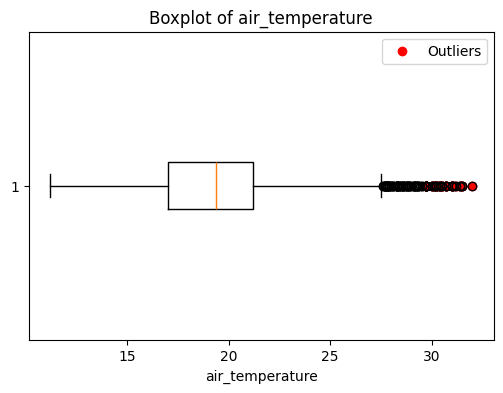

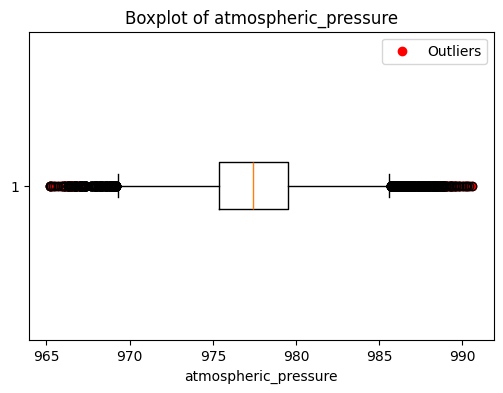

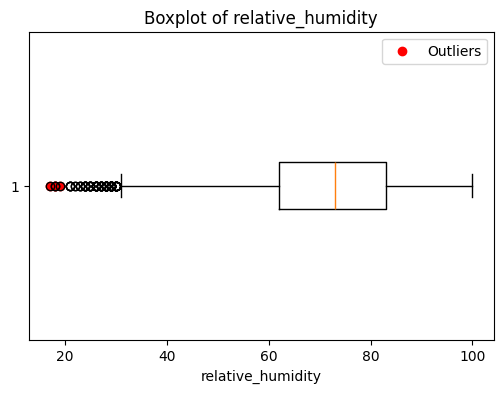

  air_temperature: [30.2, 31.4, 31.2, 30.5, 29.7, 30.7, 31.0, 30.7, 30.2, 29.7, 31.1, 31.4, 31.0, 30.0, 30.5, 30.3, 31.0, 31.5, 32.0, 31.5, 30.7, 30.4, 29.7, 30.0, 30.4, 30.4, 29.7, 30.1, 30.2, 30.1, 29.7, 29.7, 29.7]
  atmospheric_pressure: [967.1, 967.0, 966.8, 967.1, 967.0, 966.4, 966.7, 966.7, 966.9, 966.8, 967.0, 966.7, 966.1, 966.6, 966.6, 967.1, 966.8, 966.3, 966.0, 965.4, 965.2, 965.2, 966.0, 966.4, 967.1, 988.0, 987.8, 988.0, 988.6, 988.5, 987.9, 987.9, 988.4, 988.7, 989.0, 989.0, 988.7, 988.8, 988.8, 988.4, 988.0, 988.4, 988.8, 989.2, 989.8, 990.2, 990.6, 990.3, 989.6, 988.8, 988.4, 988.3, 988.4, 987.8, 988.0, 988.2, 988.5, 988.4, 988.3, 988.0, 988.0, 988.1, 988.5, 988.7, 988.2, 988.2, 988.7, 988.4, 988.0, 988.1, 988.1, 987.9, 988.2, 988.8, 989.0, 988.8, 987.9, 967.1, 966.7, 966.5, 966.5, 966.7, 966.9, 967.1, 967.0, 966.3, 965.7, 965.3, 965.5, 965.9, 966.3, 966.8, 967.0, 966.6, 966.3, 966.1, 966.1, 966.3, 966.5, 987.8, 987.8, 988.2, 987.9, 988.5, 989.3, 989.5, 988.8, 987.9, 9

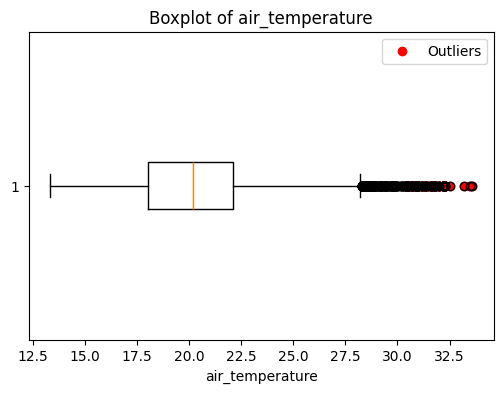

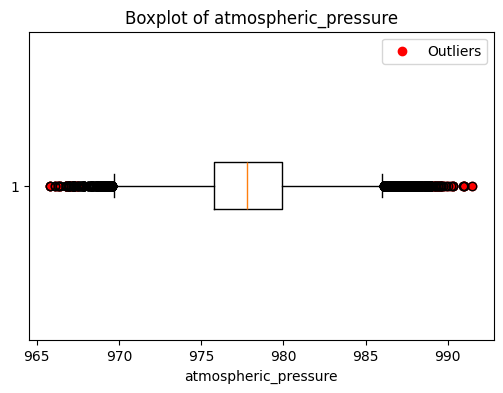

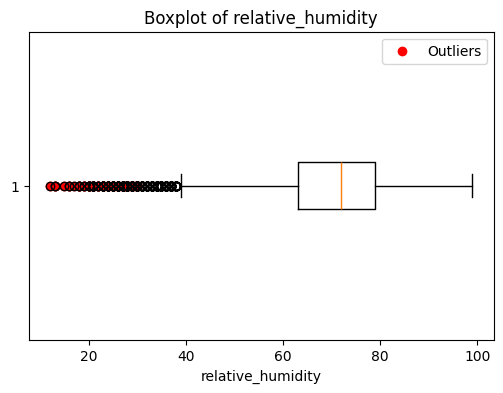

  air_temperature: [30.5, 31.0, 31.6, 31.8, 31.6, 31.3, 30.5, 31.4, 32.0, 32.3, 32.3, 31.8, 30.5, 30.5, 31.7, 32.2, 32.2, 32.2, 32.0, 30.6, 30.9, 31.0, 30.9, 30.5, 30.8, 31.2, 31.0, 30.6, 30.5, 31.2, 32.0, 32.3, 31.8, 30.7, 30.7, 31.3, 31.5, 31.3, 30.7, 30.4, 31.0, 31.4, 31.2, 30.9, 31.1, 31.3, 30.9, 31.2, 33.6, 33.5, 33.2, 32.3, 31.8, 31.7, 31.0, 30.4, 31.6, 31.9, 32.2, 32.3, 32.2, 32.3, 31.6, 30.5, 30.7, 30.9, 30.8, 30.4, 30.4, 30.9, 32.3, 32.5, 31.7, 30.7, 31.0]
  atmospheric_pressure: [967.5, 967.4, 967.3, 967.1, 967.2, 967.2, 966.9, 967.4, 967.3, 967.0, 966.3, 966.1, 966.8, 967.0, 967.3, 967.2, 967.3, 967.2, 966.8, 967.0, 988.4, 988.8, 989.0, 988.2, 988.8, 988.8, 989.0, 989.1, 989.0, 988.9, 988.6, 988.5, 988.8, 988.7, 989.4, 989.6, 990.3, 990.9, 991.5, 991.0, 990.0, 988.9, 988.3, 988.2, 988.2, 988.4, 988.4, 988.4, 988.6, 988.5, 988.4, 988.2, 988.2, 989.0, 989.4, 989.1, 988.8, 989.5, 989.2, 988.3, 988.4, 988.7, 988.6, 988.3, 988.5, 988.7, 989.0, 989.0, 989.4, 988.4, 967.2, 967.1, 9

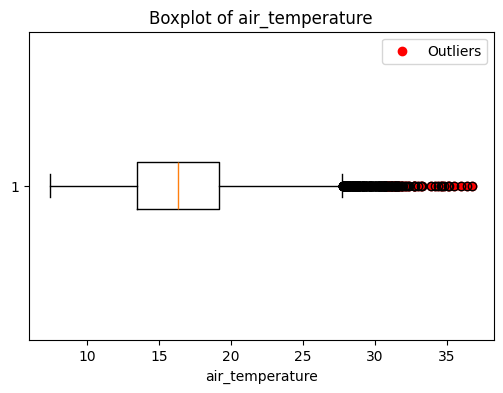

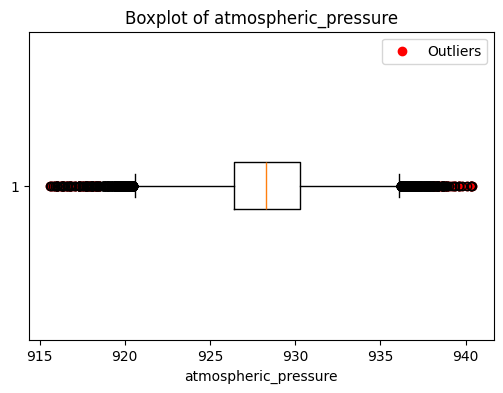

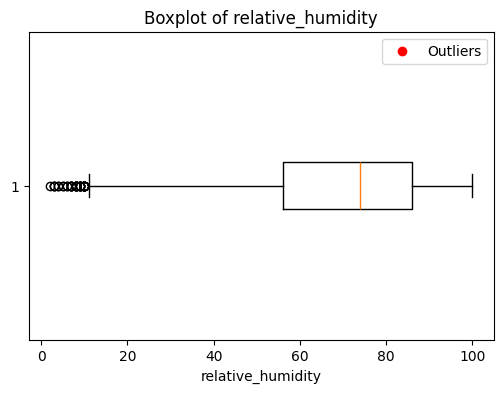

  air_temperature: [30.7, 31.6, 32.4, 31.9, 30.7, 31.0, 31.0, 31.4, 33.3, 34.7, 35.1, 35.2, 34.6, 33.0, 30.7, 30.8, 30.9, 31.2, 30.8, 31.8, 34.2, 36.0, 36.8, 36.4, 35.5, 32.7, 32.7, 33.9, 34.8, 34.4, 33.2, 31.5, 31.4, 30.8, 30.7, 30.6, 31.4, 32.0, 31.8, 31.4, 31.2, 31.1, 30.7, 30.7, 31.6, 31.6, 31.6, 31.1, 30.7, 31.3, 31.5, 31.4, 30.9, 31.6, 32.8, 32.3, 31.7, 31.5, 30.7, 32.1, 32.2, 31.2, 30.7, 30.7, 31.1, 30.8, 31.0, 31.2, 30.7, 30.6, 30.7]
  atmospheric_pressure: [918.4, 918.5, 918.3, 917.9, 917.7, 917.9, 918.0, 918.4, 918.5, 918.1, 917.7, 918.1, 918.5, 918.5, 918.2, 918.1, 918.3, 917.8, 917.5, 917.8, 917.7, 918.1, 918.1, 918.0, 917.1, 916.6, 916.3, 915.8, 915.7, 916.0, 916.8, 917.3, 917.9, 938.2, 938.4, 938.4, 938.1, 938.1, 938.9, 939.6, 940.3, 940.3, 939.4, 938.6, 938.4, 938.2, 938.4, 938.1, 938.6, 938.7, 938.4, 938.3, 938.9, 938.3, 918.1, 917.5, 916.8, 916.4, 916.2, 916.4, 916.6, 916.8, 917.4, 917.3, 917.7, 917.3, 916.4, 916.0, 915.6, 915.9, 916.5, 916.8, 916.9, 917.3, 917.7, 917.

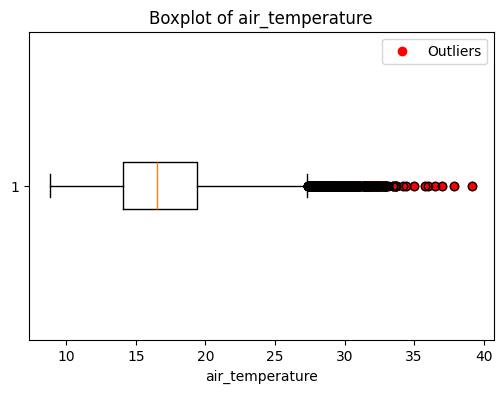

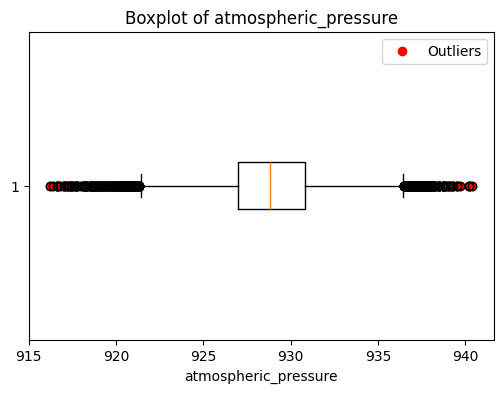

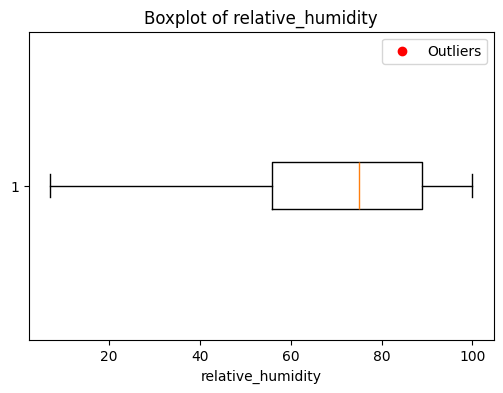

  air_temperature: [30.6, 30.8, 30.7, 30.1, 30.2, 30.9, 30.1, 30.3, 31.4, 33.0, 33.7, 33.0, 32.4, 31.7, 31.1, 30.5, 30.2, 30.9, 32.3, 31.9, 32.0, 30.9, 32.1, 32.7, 31.8, 33.5, 36.0, 36.5, 39.2, 37.0, 35.0, 33.6, 32.7, 30.7, 30.5, 31.3, 32.2, 31.5, 33.5, 33.7, 37.9, 35.8, 34.4, 33.7, 33.1, 31.0, 30.0, 31.7, 32.0, 32.1, 32.7, 32.9, 32.5, 34.2, 33.0, 32.1, 30.7, 30.7, 31.9, 32.8, 31.9, 32.3, 31.7, 30.8, 30.0, 30.4, 30.7, 30.7, 30.3, 30.1, 30.2, 31.4, 31.6, 32.3, 32.5, 32.3, 31.6, 30.4, 30.7, 31.1, 32.9, 31.8, 32.9, 32.9, 32.3, 31.6, 31.0, 31.5, 31.0, 30.8, 30.2, 30.2, 30.1, 30.8, 31.7, 32.0, 31.6, 30.8, 31.1, 31.6, 31.9, 31.5, 31.0, 30.0, 30.7, 31.9, 32.9, 32.6, 31.0, 31.4, 32.2, 31.5, 32.6, 32.5, 31.4, 30.6, 30.4, 31.4, 30.4, 30.4, 30.3, 30.5, 31.2, 31.5, 30.7, 30.0, 30.2, 30.0, 30.2, 30.9, 31.3, 30.8, 30.1, 30.1, 31.0, 31.4, 31.5, 30.6, 30.9, 31.0, 30.8, 30.2, 30.1, 30.0]
  atmospheric_pressure: [919.2, 918.8, 918.5, 918.9, 919.3, 919.1, 919.4, 919.3, 919.0, 918.7, 918.2, 918.1, 918.7, 

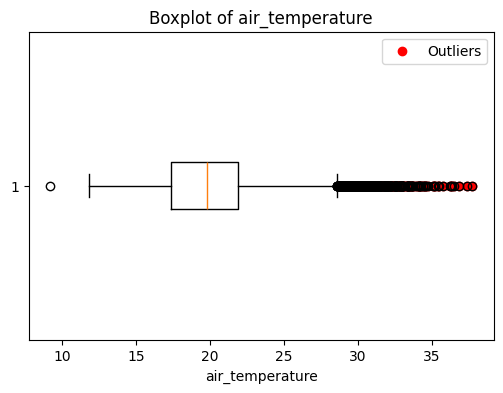

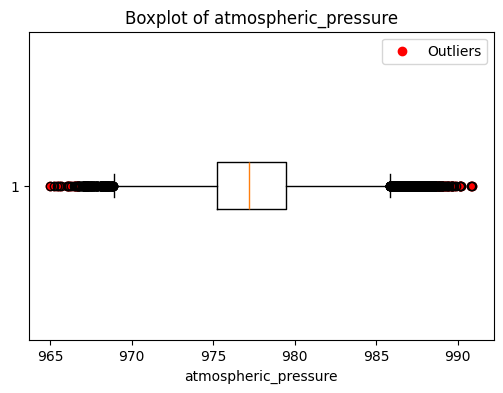

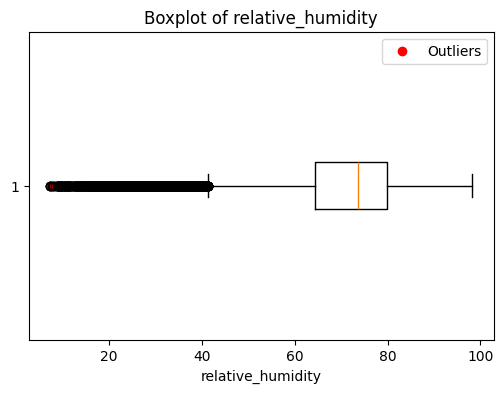

  air_temperature: [31.480868339538564, 31.3459685643514, 32.9940611521403, 32.89579836527505, 33.15436871846517, 33.66219329833984, 31.950400034586618, 32.58973534901937, 32.16642824808756, 31.72081661224365, 31.351323445638016, 32.80229250590006, 32.996363957723, 33.36702982584635, 34.27656873067222, 34.77749633789063, 34.4558048248291, 33.505463282267264, 32.54533386230468, 31.273805300394685, 31.4867401123047, 34.114881515502915, 34.24979972839356, 34.549748738606766, 32.68586858113607, 35.23801867167153, 35.511713663736984, 35.45179239908852, 35.770933787027985, 35.189173380533866, 34.6249720255534, 33.060881932576514, 31.464016278584797, 32.04893366495768, 31.969721158345532, 31.530131975809734, 31.73251978556313, 31.844275156656902, 32.95603879292806, 31.760604858398434, 30.896328608195002, 31.352622985839833, 34.00645701090493, 32.8175080617269, 34.14561653137205, 33.586409886678084, 35.11753590901693, 36.358816146850586, 36.54110463460288, 36.83545176188152, 37.371484756469734

In [165]:
for file_key, df_hourly in dataframes.items():
    print(f"Outliers detected in {file_key}:")
    
    # Use 2 as threshold for the IQR method
    outliers = detect_outliers_iqr(df_hourly, 2.0)
    for column, values in outliers.items():
        print(f"  {column}: {values}")

## Escritura fichero 